In [331]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

plt.rc('font', family='Malgun Gothic')  # 폰트 지정
plt.rc('axes', unicode_minus=False)  # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'  # 그래프 글씨 뚜렷

In [332]:
df_train = pd.read_csv("../data/df_train_005.csv")
df_test = pd.read_csv("../data/df_test_005.csv")

In [333]:
X = df_train.drop(columns = 'ECLO',axis=1)
y = df_train['ECLO']

In [334]:
x_train, x_test, y_train , y_test = train_test_split(X, y, test_size = 0.2, random_state=42 )

In [335]:
import os
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

# torch

In [336]:
import torch
import torch.nn as nn
import torch.optim as optim

In [337]:
# 데이터를 PyTorch Tensor로 변환
x_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values.reshape(-1,1), dtype=torch.float32)

In [338]:
# Autoencoder 모델 정의
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),  # 입력 차원: input_dim, 은닉층 차원: 128
            nn.ReLU(),
            nn.Linear(128, 64),  # 은닉층 차원: 128, 출력 차원: 64
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),  # 입력 차원: 64, 은닉층 차원: 128
            nn.ReLU(),
            nn.Linear(128, 1),  # 은닉층 차원: 128, 출력 차원: 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [339]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super(RMSLELoss, self).__init__()

    def forward(self, predicted, target):
        """
        predicted: 예측값
        target: 실제값
        """
        loss = torch.sqrt(torch.mean((torch.log1p(predicted) - torch.log1p(target))**2))
        return loss

In [340]:
# 모델 인스턴스 생성 및 손실 함수, 옵티마이저 정의
model = Autoencoder(input_dim=226)
criterion = RMSLELoss() #nn.HuberLoss(delta=0.2), nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [341]:
# 학습
num_epochs = 500
for epoch in range(num_epochs):
    # Forward Pass
    outputs = model(x_tensor)

    # Loss 계산
    loss = criterion(outputs, y_tensor)

    # Backward Pass 및 최적화
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 로그 출력
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [0/500], Loss: 1.6133
Epoch [10/500], Loss: 0.4771
Epoch [20/500], Loss: 0.4805
Epoch [30/500], Loss: 0.4539
Epoch [40/500], Loss: 0.4453
Epoch [50/500], Loss: 0.4460
Epoch [60/500], Loss: 0.4438
Epoch [70/500], Loss: 0.4424
Epoch [80/500], Loss: 0.4409
Epoch [90/500], Loss: 0.4395
Epoch [100/500], Loss: 0.4385
Epoch [110/500], Loss: 0.4379
Epoch [120/500], Loss: 0.4375
Epoch [130/500], Loss: 0.4371
Epoch [140/500], Loss: 0.4365
Epoch [150/500], Loss: 0.4354
Epoch [160/500], Loss: 0.4337
Epoch [170/500], Loss: 0.4313
Epoch [180/500], Loss: 0.4289
Epoch [190/500], Loss: 0.4304
Epoch [200/500], Loss: 0.4256
Epoch [210/500], Loss: 0.4225
Epoch [220/500], Loss: 0.4215
Epoch [230/500], Loss: 0.4183
Epoch [240/500], Loss: 0.4173
Epoch [250/500], Loss: 0.4170
Epoch [260/500], Loss: 0.4143
Epoch [270/500], Loss: 0.4126
Epoch [280/500], Loss: 0.4183
Epoch [290/500], Loss: 0.4132
Epoch [300/500], Loss: 0.4111
Epoch [310/500], Loss: 0.4097
Epoch [320/500], Loss: 0.4083
Epoch [330/500], Loss

In [342]:
# 학습된 모델을 사용하여 예측
with torch.no_grad():
    predicted = model(x_tensor).numpy()

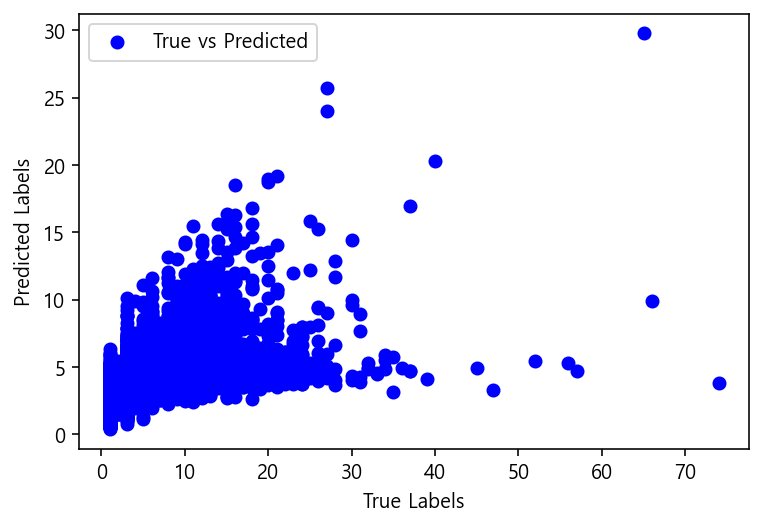

In [343]:
# 시각화
plt.scatter(y.values.reshape(-1,1), predicted, label='True vs Predicted', color='blue')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.legend()
plt.show()

In [344]:
sub_file = pd.read_csv("../data/sample_submission.csv")

In [345]:
df_test_tensor = torch.tensor(df_test.values, dtype=torch.float32)

In [346]:
sub_file.ECLO = model(df_test_tensor).detach().numpy()

<AxesSubplot:>

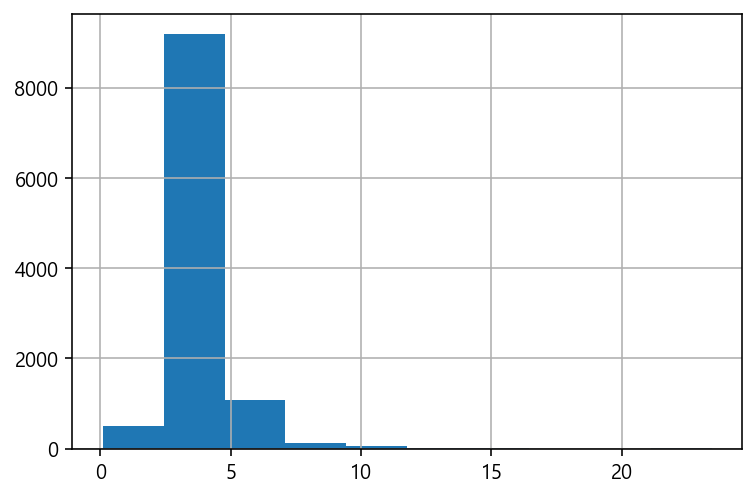

In [347]:
sub_file.ECLO.hist()

In [348]:
sub_file.to_csv("../data/sub_file/020autoencoder.csv", index=False)